In [1]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset

In [2]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [3]:
x_train.shape

(10063, 10, 160)

In [4]:
y_train.shape

(10063,)

In [5]:
x_val.shape

(2156, 10, 160)

In [6]:
y_val.shape

(2156,)

In [7]:
x_test.shape

(2157, 10, 160)

In [8]:
y_test.shape

(2157,)

In [9]:
team_a_train = x_train[:, -1, 0].astype(int)
team_b_train = x_train[:, -1, 1].astype(int)

team_a_val = x_val[:, -1, 0].astype(int)
team_b_val = x_val[:, -1, 1].astype(int)

team_a_test = x_test[:, -1, 0].astype(int)
team_b_test = x_test[:, -1, 1].astype(int)

print("Team A unique values:", np.unique(team_a_train))
print("Team B unique values:", np.unique(team_b_train))

Team A unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Team B unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


In [10]:
team_a_train = torch.tensor(team_a_train, dtype=torch.long)
team_b_train = torch.tensor(team_b_train, dtype=torch.long)

team_a_val = torch.tensor(team_a_val, dtype=torch.long)
team_b_val = torch.tensor(team_b_val, dtype=torch.long)

team_a_test = torch.tensor(team_a_test, dtype=torch.long)
team_b_test = torch.tensor(team_b_test, dtype=torch.long)


In [11]:
x_train = x_train[:, :, 2:]
x_val = x_val[:, :, 2:]
x_test = x_test[:, :, 2:]

x_train = torch.tensor(x_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [12]:
y_train = y_train.unsqueeze(1)
y_val = y_val.unsqueeze(1)
y_test = y_test.unsqueeze(1)

Number of teams: 30
Input size: 158
Sequence length: 10
Model parameters: 313,537
Epoch   0: Train Loss: 0.6384, Val Loss: 0.6782, Train Acc: 0.641, Val Acc: 0.587, Train R²: -1.373, Val R²: -1.469, LR: 0.001000
Epoch   1: Train Loss: 0.6268, Val Loss: 0.6609, Train Acc: 0.661, Val Acc: 0.613, Train R²: -1.446, Val R²: -1.531, LR: 0.001000
Epoch   2: Train Loss: 0.6114, Val Loss: 0.6688, Train Acc: 0.672, Val Acc: 0.589, Train R²: -1.896, Val R²: -2.163, LR: 0.001000
Epoch   3: Train Loss: 0.5981, Val Loss: 0.6625, Train Acc: 0.684, Val Acc: 0.605, Train R²: -1.613, Val R²: -1.445, LR: 0.001000
Epoch   4: Train Loss: 0.5680, Val Loss: 0.6692, Train Acc: 0.706, Val Acc: 0.607, Train R²: -2.705, Val R²: -2.374, LR: 0.001000
Epoch   5: Train Loss: 0.5483, Val Loss: 0.6881, Train Acc: 0.722, Val Acc: 0.602, Train R²: -2.271, Val R²: -1.733, LR: 0.001000
Epoch   6: Train Loss: 0.5204, Val Loss: 0.6628, Train Acc: 0.767, Val Acc: 0.603, Train R²: -2.342, Val R²: -2.345, LR: 0.001000
Epoch   

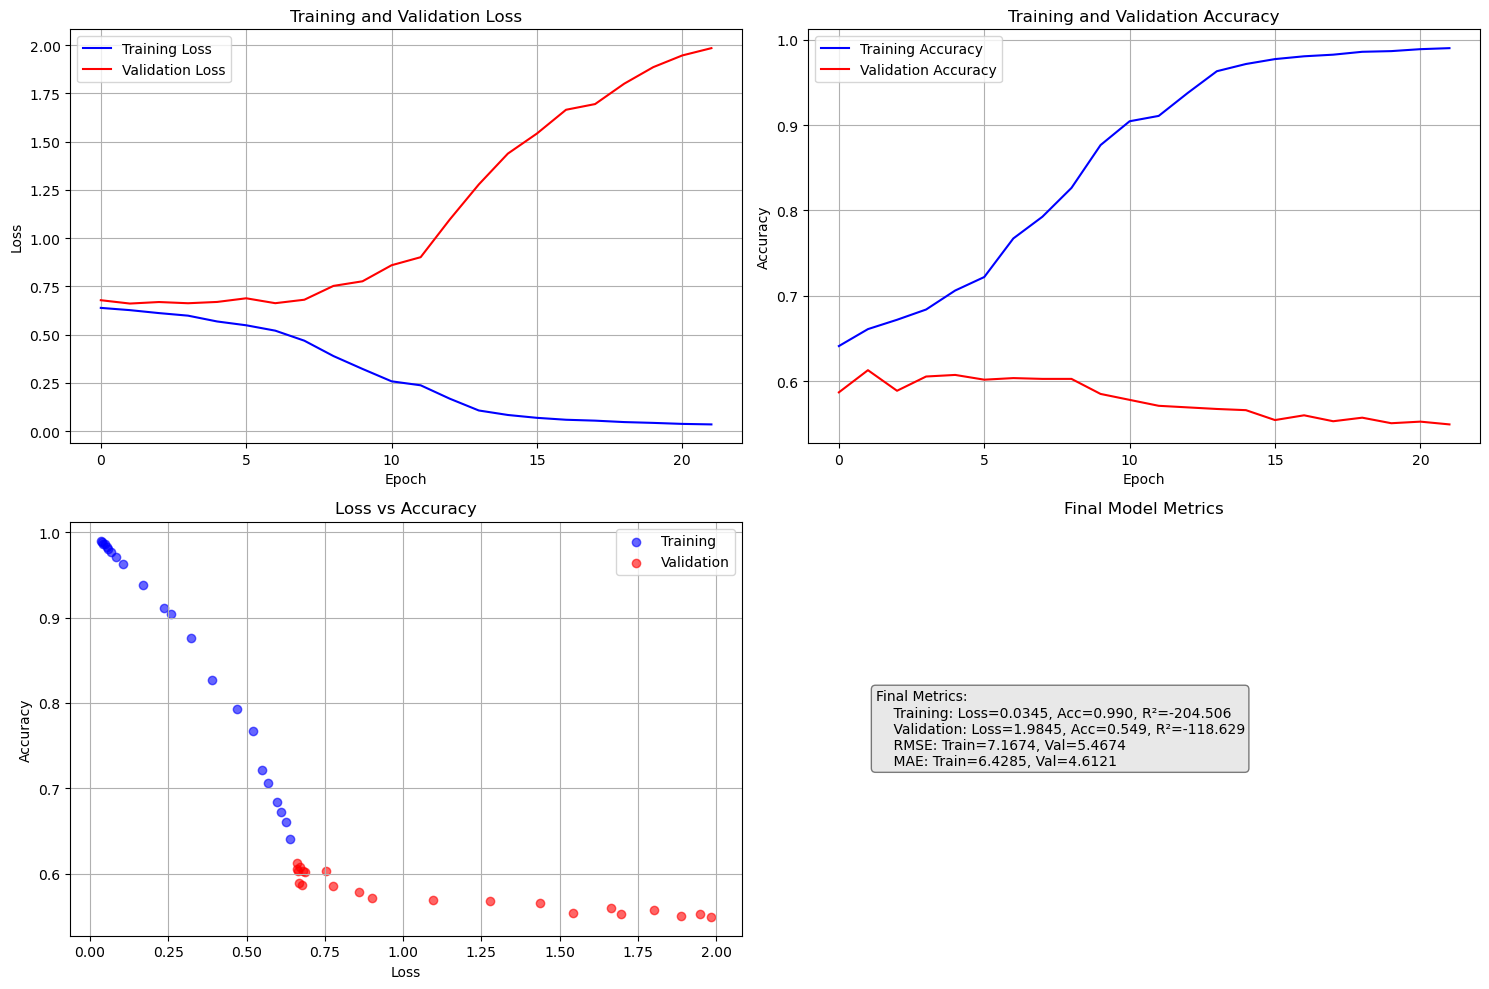

Test Loss: 25.9143


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LSTMWithTeamEmbeddings(nn.Module):
    def __init__(self, num_teams, embedding_dim, input_size, hidden_size, 
                 num_layers=2, dropout=0.2, output_size=1):
        super(LSTMWithTeamEmbeddings, self).__init__()
        
        # Team embeddings
        self.team_embedding = nn.Embedding(num_teams, embedding_dim)
        
        # LSTM for sequential features
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Combine LSTM output with team embeddings
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size + 2 * embedding_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x_seq, team_a, team_b):
        batch_size = x_seq.size(0)
        
        # LSTM processing
        lstm_out, (hidden, cell) = self.lstm(x_seq)
        # Use the last output
        lstm_final = torch.max(lstm_out, dim=1).values
        
        # Team embeddings
        team_a_emb = self.team_embedding(team_a)  # Shape: (batch_size, embedding_dim)
        team_b_emb = self.team_embedding(team_b)  # Shape: (batch_size, embedding_dim)
        
        # Concatenate LSTM output with team embeddings
        combined = torch.cat([lstm_final, team_a_emb, team_b_emb], dim=1)
        
        # Final prediction
        output = self.fc_layers(combined)
        return output

# Example usage and training setup
def create_model(num_teams, input_size):
    model = LSTMWithTeamEmbeddings(
        num_teams=num_teams,
        embedding_dim=32,  # Adjust based on your needs
        input_size=input_size,
        hidden_size=128,
        num_layers=2,
        dropout=0.2,
        output_size=1
    )
    return model

# Helper function to calculate accuracy metrics
def calculate_metrics(model, dataloader, device, task_type='regression'):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    criterion = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        for x_batch, team_a_batch, team_b_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            team_a_batch = team_a_batch.to(device)
            team_b_batch = team_b_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(x_batch, team_a_batch, team_b_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    
    # Convert to numpy arrays
    predictions = np.array(all_predictions)
    targets = np.array(all_targets)
    
    # Calculate metrics
    mse = np.mean((predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - targets))
    
    # R-squared
    ss_res = np.sum((targets - predictions) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    # For sports predictions, you might also want classification accuracy
    # Assuming positive values mean team A wins, negative means team B wins
    probs = torch.sigmoid(torch.tensor(predictions))
    pred_winners = (probs > 0.5).int().numpy()
    true_winners = (targets > 0).astype(int)
    accuracy = np.mean(pred_winners == true_winners)

    
    return {
        'loss': avg_loss,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'accuracy': accuracy
    }

# Training function
def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.001):
    import matplotlib.pyplot as plt
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.BCEWithLogitsLoss() #for classification
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
    
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    
    # Track losses and metrics for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for x_batch, team_a_batch, team_b_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            team_a_batch = team_a_batch.to(device)
            team_b_batch = team_b_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(x_batch, team_a_batch, team_b_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Calculate detailed metrics every epoch
        train_metrics = calculate_metrics(model, train_loader, device)
        val_metrics = calculate_metrics(model, val_loader, device)
        
        # Store metrics for plotting
        train_losses.append(train_metrics['loss'])
        val_losses.append(val_metrics['loss'])
        train_accuracies.append(train_metrics['accuracy'])
        val_accuracies.append(val_metrics['accuracy'])
        
        scheduler.step(val_metrics['loss'])
        
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        # Print comprehensive metrics every epoch
        print(f'Epoch {epoch:3d}: '
              f'Train Loss: {train_metrics["loss"]:.4f}, '
              f'Val Loss: {val_metrics["loss"]:.4f}, '
              f'Train Acc: {train_metrics["accuracy"]:.3f}, '
              f'Val Acc: {val_metrics["accuracy"]:.3f}, '
              f'Train R²: {train_metrics["r2"]:.3f}, '
              f'Val R²: {val_metrics["r2"]:.3f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    # Plot training curves
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy curves
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # R² curves
    train_r2 = [calculate_metrics(model, train_loader, device)['r2'] for _ in range(len(train_losses))]
    val_r2 = [calculate_metrics(model, val_loader, device)['r2'] for _ in range(len(val_losses))]
    
    # Loss vs Accuracy scatter
    ax3.scatter(train_losses, train_accuracies, alpha=0.6, label='Training', color='blue')
    ax3.scatter(val_losses, val_accuracies, alpha=0.6, label='Validation', color='red')
    ax3.set_xlabel('Loss')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Loss vs Accuracy')
    ax3.legend()
    ax3.grid(True)
    
    # Final epoch detailed metrics
    final_train_metrics = calculate_metrics(model, train_loader, device)
    final_val_metrics = calculate_metrics(model, val_loader, device)
    
    metrics_text = f"""Final Metrics:
    Training: Loss={final_train_metrics['loss']:.4f}, Acc={final_train_metrics['accuracy']:.3f}, R²={final_train_metrics['r2']:.3f}
    Validation: Loss={final_val_metrics['loss']:.4f}, Acc={final_val_metrics['accuracy']:.3f}, R²={final_val_metrics['r2']:.3f}
    RMSE: Train={final_train_metrics['rmse']:.4f}, Val={final_val_metrics['rmse']:.4f}
    MAE: Train={final_train_metrics['mae']:.4f}, Val={final_val_metrics['mae']:.4f}"""
    
    ax4.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center', 
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    ax4.set_title('Final Model Metrics')
    
    plt.tight_layout()
    plt.show()
    
    return model

# Create DataLoader
from torch.utils.data import Dataset, DataLoader

class SportsDataset(Dataset):
    def __init__(self, x_seq, team_a, team_b, y):
        self.x_seq = x_seq
        self.team_a = team_a
        self.team_b = team_b
        self.y = y
    
    def __len__(self):
        return len(self.x_seq)
    
    def __getitem__(self, idx):
        return self.x_seq[idx], self.team_a[idx], self.team_b[idx], self.y[idx]

# Usage example:
if __name__ == "__main__":
    # Assuming your data is already preprocessed as in your code
    
    # Get dimensions
    # Handle both numpy arrays and tensors
    if isinstance(team_a_train, torch.Tensor):
        max_team_a = torch.max(team_a_train).item()
        max_team_b = torch.max(team_b_train).item()
    else:
        max_team_a = int(np.max(team_a_train))
        max_team_b = int(np.max(team_b_train))
    
    num_teams = max(max_team_a, max_team_b) + 1
    input_size = x_train.size(2)  # Number of features per time step
    
    print(f"Number of teams: {num_teams}")
    print(f"Input size: {input_size}")
    print(f"Sequence length: {x_train.size(1)}")
    
    # Create datasets and dataloaders
    train_dataset = SportsDataset(x_train, team_a_train, team_b_train, y_train)
    val_dataset = SportsDataset(x_val, team_a_val, team_b_val, y_val)
    test_dataset = SportsDataset(x_test, team_a_test, team_b_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Create and train model
    model = create_model(num_teams, input_size)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train the model
    trained_model = train_model(model, train_loader, val_loader)
    
    # Test the model
    trained_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_batch, team_a_batch, team_b_batch, y_batch in test_loader:
            outputs = trained_model(x_batch, team_a_batch, team_b_batch)
            loss = nn.MSELoss()(outputs, y_batch)
            test_loss += loss.item()
    
    print(f"Test Loss: {test_loss / len(test_loader):.4f}")

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LSTMWithTeamEmbeddings(nn.Module):
    def __init__(self, num_teams, embedding_dim, input_size, hidden_size, 
                 num_layers=2, dropout=0.2, output_size=1):
        super(LSTMWithTeamEmbeddings, self).__init__()
        
        # Team embeddings
        self.team_embedding = nn.Embedding(num_teams, embedding_dim)
        
        # LSTM for sequential features + team embeddings
        # Input size now includes team embeddings
        lstm_input_size = input_size + 2 * embedding_dim
        
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Final prediction layer (just a single linear layer)
        self.prediction_layer = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x_seq, team_a, team_b):
        batch_size, seq_len, _ = x_seq.size()
        
        # Get team embeddings
        team_a_emb = self.team_embedding(team_a)  # Shape: (batch_size, embedding_dim)
        team_b_emb = self.team_embedding(team_b)  # Shape: (batch_size, embedding_dim)
        
        # Expand team embeddings to match sequence length
        team_a_expanded = team_a_emb.unsqueeze(1).expand(-1, seq_len, -1)  # (batch_size, seq_len, embedding_dim)
        team_b_expanded = team_b_emb.unsqueeze(1).expand(-1, seq_len, -1)  # (batch_size, seq_len, embedding_dim)
        
        # Concatenate sequential features with team embeddings at each time step
        lstm_input = torch.cat([x_seq, team_a_expanded, team_b_expanded], dim=2)
        
        # LSTM processing
        lstm_out, (hidden, cell) = self.lstm(lstm_input)
        
        # Use the final hidden state for prediction
        final_hidden = hidden[-1]  # Take the last layer's hidden state
        
        # Direct prediction from LSTM output
        output = self.prediction_layer(final_hidden)
        
        return output

# Alternative version using the last time step output instead of hidden state
class LSTMWithTeamEmbeddingsV2(nn.Module):
    def __init__(self, num_teams, embedding_dim, input_size, hidden_size, 
                 num_layers=2, dropout=0.2, output_size=1):
        super(LSTMWithTeamEmbeddingsV2, self).__init__()
        
        # Team embeddings
        self.team_embedding = nn.Embedding(num_teams, embedding_dim)
        
        # LSTM for sequential features + team embeddings
        lstm_input_size = input_size + 2 * embedding_dim
        
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Final prediction layer
        self.prediction_layer = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x_seq, team_a, team_b):
        batch_size, seq_len, _ = x_seq.size()
        
        # Get team embeddings
        team_a_emb = self.team_embedding(team_a)  # Shape: (batch_size, embedding_dim)
        team_b_emb = self.team_embedding(team_b)  # Shape: (batch_size, embedding_dim)
        
        # Expand team embeddings to match sequence length
        team_a_expanded = team_a_emb.unsqueeze(1).expand(-1, seq_len, -1)
        team_b_expanded = team_b_emb.unsqueeze(1).expand(-1, seq_len, -1)
        
        # Concatenate sequential features with team embeddings at each time step
        lstm_input = torch.cat([x_seq, team_a_expanded, team_b_expanded], dim=2)
        
        # LSTM processing
        lstm_out, (hidden, cell) = self.lstm(lstm_input)
        
        # Use the last time step output for prediction
        last_output = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_size)
        
        # Direct prediction from LSTM output
        output = self.prediction_layer(last_output)
        
        return output

# Example usage and training setup
def create_model(num_teams, input_size, version=1):
    if version == 1:
        model = LSTMWithTeamEmbeddings(
            num_teams=num_teams,
            embedding_dim=32,  # Adjust based on your needs
            input_size=input_size,
            hidden_size=128,
            num_layers=2,
            dropout=0.2,
            output_size=1
        )
    else:
        model = LSTMWithTeamEmbeddingsV2(
            num_teams=num_teams,
            embedding_dim=32,
            input_size=input_size,
            hidden_size=128,
            num_layers=2,
            dropout=0.2,
            output_size=1
        )
    return model

# Helper function to calculate accuracy metrics
def calculate_metrics(model, dataloader, device, task_type='regression'):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    criterion = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        for x_batch, team_a_batch, team_b_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            team_a_batch = team_a_batch.to(device)
            team_b_batch = team_b_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(x_batch, team_a_batch, team_b_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    
    # Convert to numpy arrays
    predictions = np.array(all_predictions)
    targets = np.array(all_targets)
    
    # Calculate metrics
    mse = np.mean((predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - targets))
    
    # R-squared
    ss_res = np.sum((targets - predictions) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    # For sports predictions, you might also want classification accuracy
    # Assuming positive values mean team A wins, negative means team B wins
    probs = torch.sigmoid(torch.tensor(predictions))
    pred_winners = (probs > 0.5).int().numpy()
    true_winners = (targets > 0).astype(int)
    accuracy = np.mean(pred_winners == true_winners)
    
    return {
        'loss': avg_loss,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'accuracy': accuracy
    }

# Training function remains the same
def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.001):
    import matplotlib.pyplot as plt
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
    
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for x_batch, team_a_batch, team_b_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            team_a_batch = team_a_batch.to(device)
            team_b_batch = team_b_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(x_batch, team_a_batch, team_b_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Calculate detailed metrics every epoch
        train_metrics = calculate_metrics(model, train_loader, device)
        val_metrics = calculate_metrics(model, val_loader, device)
        
        train_losses.append(train_metrics['loss'])
        val_losses.append(val_metrics['loss'])
        train_accuracies.append(train_metrics['accuracy'])
        val_accuracies.append(val_metrics['accuracy'])
        
        scheduler.step(val_metrics['loss'])
        
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        print(f'Epoch {epoch:3d}: '
              f'Train Loss: {train_metrics["loss"]:.4f}, '
              f'Val Loss: {val_metrics["loss"]:.4f}, '
              f'Train Acc: {train_metrics["accuracy"]:.3f}, '
              f'Val Acc: {val_metrics["accuracy"]:.3f}, '
              f'Train R²: {train_metrics["r2"]:.3f}, '
              f'Val R²: {val_metrics["r2"]:.3f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    return model

# Dataset class remains the same
from torch.utils.data import Dataset, DataLoader

class SportsDataset(Dataset):
    def __init__(self, x_seq, team_a, team_b, y):
        self.x_seq = x_seq
        self.team_a = team_a
        self.team_b = team_b
        self.y = y
    
    def __len__(self):
        return len(self.x_seq)
    
    def __getitem__(self, idx):
        return self.x_seq[idx], self.team_a[idx], self.team_b[idx], self.y[idx]

# Usage example:
if __name__ == "__main__":
    # Get dimensions
    if isinstance(team_a_train, torch.Tensor):
        max_team_a = torch.max(team_a_train).item()
        max_team_b = torch.max(team_b_train).item()
    else:
        max_team_a = int(np.max(team_a_train))
        max_team_b = int(np.max(team_b_train))
    
    num_teams = max(max_team_a, max_team_b) + 1
    input_size = x_train.size(2)  # Number of features per time step
    
    print(f"Number of teams: {num_teams}")
    print(f"Input size: {input_size}")
    print(f"Sequence length: {x_train.size(1)}")
    
    # Create datasets and dataloaders
    train_dataset = SportsDataset(x_train, team_a_train, team_b_train, y_train)
    val_dataset = SportsDataset(x_val, team_a_val, team_b_val, y_val)
    test_dataset = SportsDataset(x_test, team_a_test, team_b_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Create and train model (version 1 uses final hidden state, version 2 uses last output)
    model = create_model(num_teams, input_size, version=1)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train the model
    trained_model = train_model(model, train_loader, val_loader)
    
    # Test the model
    test_metrics = calculate_metrics(trained_model, test_loader, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    print(f"Test Metrics: {test_metrics}")

Number of teams: 30
Input size: 158
Sequence length: 10
Model parameters: 313,409
Epoch   0: Train Loss: 0.6255, Val Loss: 0.6492, Train Acc: 0.652, Val Acc: 0.630, Train R²: -1.375, Val R²: -1.077, LR: 0.001000
Epoch   1: Train Loss: 0.5982, Val Loss: 0.6493, Train Acc: 0.684, Val Acc: 0.632, Train R²: -1.348, Val R²: -1.160, LR: 0.001000
Epoch   2: Train Loss: 0.5485, Val Loss: 0.6496, Train Acc: 0.722, Val Acc: 0.634, Train R²: -3.282, Val R²: -2.562, LR: 0.001000
Epoch   3: Train Loss: 0.4953, Val Loss: 0.6519, Train Acc: 0.792, Val Acc: 0.615, Train R²: -2.631, Val R²: -2.477, LR: 0.001000
Epoch   4: Train Loss: 0.4228, Val Loss: 0.6885, Train Acc: 0.826, Val Acc: 0.590, Train R²: -5.416, Val R²: -5.476, LR: 0.001000
Epoch   5: Train Loss: 0.3012, Val Loss: 0.7355, Train Acc: 0.894, Val Acc: 0.577, Train R²: -10.615, Val R²: -5.766, LR: 0.001000
Epoch   6: Train Loss: 0.2196, Val Loss: 0.8079, Train Acc: 0.935, Val Acc: 0.574, Train R²: -19.259, Val R²: -9.378, LR: 0.001000
Epoch 